This is the exact solution of the adviction equation in 1D with 1 wave going from left to right at a constant speed.

In [106]:
import numpy as np
from sympy import *
import matplotlib.pyplot as plt
from IPython.display import display, clear_output # this is for plotting animations
import sys
init_printing()

The equation we are trying to model is the advection equation:

$$q_x + \hat{u}q_t = 0$$

making of the initial data

In [116]:
# we have x on an interval [0,2], t = [0,1] and we timestep each in 1001 steps, which gives us 1000 intervals
Nx_points = 1001
min_x = 0 
max_x = 1
length_x = max_x - min_x
Nx_intervals = Nx_points-1
dx_points = 1/Nx_intervals
dt = 0.001
t_end = 5
Nt = int(t_end/dt)
t = np.linspace(0,t_end,Nt+1)
Ax_points = np.linspace(0,length_x,Nx_points)
Nx_integrals = 0 # will never be 0, just need to initialize it here for scope purposes 
N_plots_shown = 100
if (Nx_intervals%10 != 0):
    print("x_points is not a multiple of 10, this will cause problems in the integral")
    sys.exit()
else:
    Nx_integrals = Nx_intervals//10
N_p_pr_integral = Nx_intervals/Nx_integrals # the right boundary does not add anything to the last integral 
dx_integrals = length_x/Nx_integrals
u_hat = 0.7 # this is the speed of the single wave 
CFL_points = u_hat*dt/dx_points
CFL_integrals = u_hat*dt/dx_integrals
print("CFL for points: " + str(CFL_points))
print("CFL for integrals: " + str(CFL_integrals))

CFL for points: 0.7
CFL for integrals: 0.06999999999999999


Generating 3 initial waves. 
1. Discountinues from a saw wave.
2. Gaussian curve with $\sigma = 0.07$ and $\mu = 0.5$
3. Dambreak at x=0.5 with the value 5 on the lhs and 0 on the rhs

In [117]:
# write 0 below for discontinuous wave, 1 for gaussian wave and 2 for dambreak wave
current_wave = 1 
# defining initial-condition for a discontinuous wave
initial_dis_wave = np.zeros(Nx_points) 
for i in range(0,Nx_points//3):
    initial_dis_wave[int(Nx_points/4)+i] = i*(25/Nx_points)
# defining initial for a gaussian wave 
sigma = 0.07 
mu = 0.5 
initial_gaus_wave =1/(sigma*np.sqrt(2))*np.exp(-0.5*((Ax_points-mu)/sigma)**2) 

higher_dam_break_v = 5.0
# defining initial for a dambreak wave 
initial_dam_break = np.zeros(Nx_points)
for i in range(0,int(Nx_points//2)):
    initial_dam_break[i] = higher_dam_break_v 

Making a plot of the initial waves:

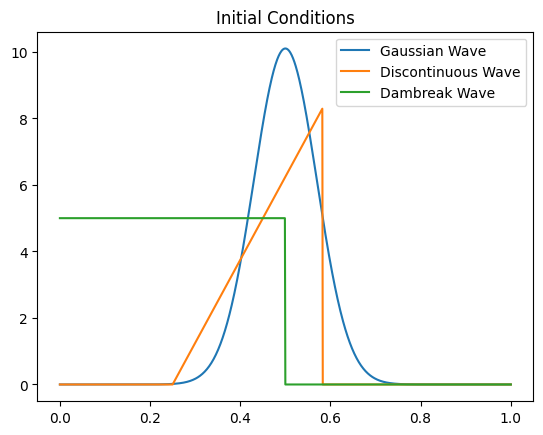

In [118]:
waves = [initial_dis_wave, initial_gaus_wave, initial_dam_break]
#plot initial waves and make sure CFL condition is satisfied
plt.plot(Ax_points,initial_gaus_wave, label = 'Gaussian Wave')
plt.plot(Ax_points,initial_dis_wave, label = 'Discontinuous Wave')
plt.plot(Ax_points,initial_dam_break, label = 'Dambreak Wave')
plt.title('Initial Conditions')
plt.legend()

Here is a pointwise upwind method applied:

$$u_i^{n+1}=u_i^n-\frac{\hat{u}\Delta t}{\Delta x}(u_i^n-u_{i-1}^n)$$

In [119]:
def exact_wave(initial_values, x, dx, n, dt, u, interval_size, step_size):
    # defining the exact solution for a single wave with transitive boundary conditions
    d = u_hat*(n+1)*dt
    while (d > interval_size):
        d = d - interval_size 
    x_on_original = np.mod(x - d,interval_size)
    index = int(x_on_original/step_size)  
    return initial_values[index]

In [124]:
def plot_scheme(fig, ax, x, data, exact_solution,CFL,dt,n, wave_type):
    ax.cla()
    ax.plot(x,data)
    ax.scatter(x,exact_solution, marker='.', facecolors='red', color='red', s=1)
    fig.gca().legend(('Upwind scheme pointwise (CFL='+str(CFL)+')','Exact solution'))
    ax.set_xlabel('x')
    ax.set_ylabel('value')
    match wave_type:
        case 0: # This is the discontinuous wave
            fig.suptitle('Saw wave t='+str(round(dt*(n+1),3)),fontsize=13)
        case 1: # This is the gaussian wave
            fig.suptitle('Gaussian wave t='+str(round(dt*(n+1),3)),fontsize=13)
        case 2: # This is the dambreak wave
            fig.suptitle('Dambreak wave t='+str(round(dt*(n+1),3)),fontsize=13)
    display(fig)
    clear_output(wait=True)
    plt.pause(0.001)

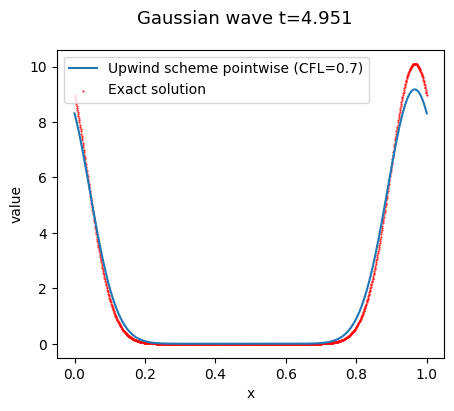

In [125]:
u_next = np.zeros(Nx_points)          
u_current = np.copy(waves[current_wave])
u_exact = np.copy(waves[current_wave])
   
for n in range (0,Nt):
    for i in range (1,Nx_points):
        u_next[i] = u_current[i] - CFL_points*(u_current[i]-u_current[i-1])
        u_exact[i] = exact_wave(waves[current_wave], Ax_points[i], dx_points, n, dt, u_hat, max_x, dx_points)  
    # we make a transitive boundary condition, where the last point is equal to the first point
    u_next[0] = u_next[Nx_points-1]
    u_exact[0] = u_exact[Nx_points-1]  
    u_current = np.copy(u_next)
    
    if (n==0): fig, ax = plt.subplots(figsize=(5,4))
    if (n%(Nt//N_plots_shown)==0): plot_scheme(fig, ax, Ax_points, u_current, u_exact, CFL_points, dt, n, current_wave)

# The error can be calculated as pr. page 252(A.17) with the 2 norm in the book Randall Leveque - Finite Difference Methods for Ordinary and Partial Differential Equations
array_diff = u_exact - u_current
error = dx_points * np.linalg.norm(array_diff,2)
plt.show()

propergation of each wave with:

$$q(x,t) = \mathring{q}(x-\hat{u}t)$$

Plotting an animation with respect to time for each of the three wave types

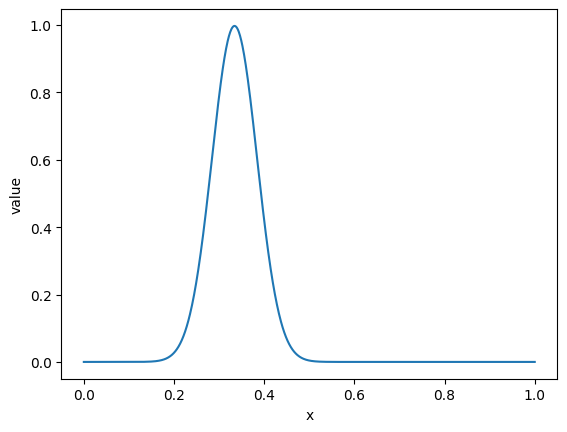

In [240]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
show_plot = 0
for t in t_array:
    show_plot = show_plot + 1
    if(show_plot == timesteps//number_of_plots_to_show):
        data = np.zeros(x_points)
        for i in range(0,len(x)):
            data[i] = calculate_exact_state_1wave(waves[current_wave], x[i], t, u_hat, 0, x_length, x_length/x_points, current_wave == 2)
        plot_scheme(fig, ax, x, data)
        show_plot = 0



Lets try and solve the same problem with a numerical solution using the FVM.
$$ Q_i^{n+1}=Q_i^n-\frac{\hat{u}\Delta t}{\Delta x}(Q_{i}^n-Q_{i-1}^n)$$

We start by setting the grid into intervals.

In [241]:
# global variables for the FVM scheme 
# interval has to be a multiple of interval_q 
if p_in_integrals.is_integer():
    p_in_integrals = int(p_in_integrals)
else:
    print('Error: p_in_integrals is not an integer')
    sys.exit(1)
Q_0 = []
for i in range(0,n_integrals):
    Q_current = 0
    for j in range(0,p_in_integrals):
        Q_current = Q_current + waves[current_wave][i*p_in_integrals+j]
    Q_0.append(Q_current/p_in_integrals)

We do the upwind method for the advection equation, this is based on 4.25 Leveque (Finite Volume):

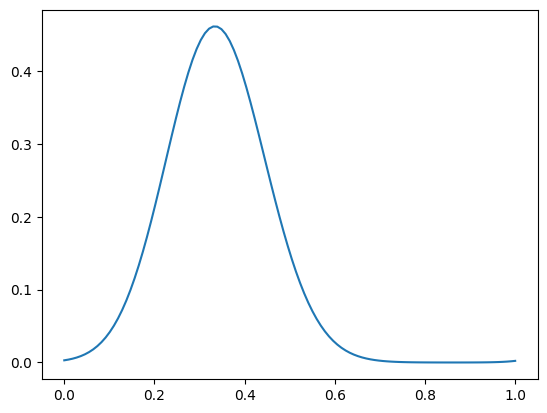

In [242]:
Q_next = np.zeros(n_integrals) 
Q_current = Q_0
x_axis = np.linspace(0,x_length,n_integrals)
for _ in range(0,timesteps):
    #setting transitive boundary conditions 
    Q_next[0] = Q_current[0]-u_hat*delta_t/delta_x*(Q_current[0]-Q_current[n_integrals-1])
    for i in range(1,n_integrals):
        Q_next[i] = Q_current[i]-(u_hat*delta_t/delta_x)*(Q_current[i]-Q_current[i-1])
    Q_current = Q_next
    if (show_plot == timesteps//number_of_plots_to_show):
        plot_scheme(fig, ax, x_axis, Q_current)
        show_plot = 0
    show_plot = show_plot + 1
plt.plot(x_axis,Q_current)

Doing the same scheme as without volume.
$$ q_i^{n+1}=q_i^n-\frac{\hat{u}\Delta t}{\Delta x}(q_{i}^n-q_{i-1}^n)$$

[0.00000000e+00 5.00250125e-04 1.00050025e-03 ... 9.98999500e-01
 9.99499750e-01 1.00000000e+00]


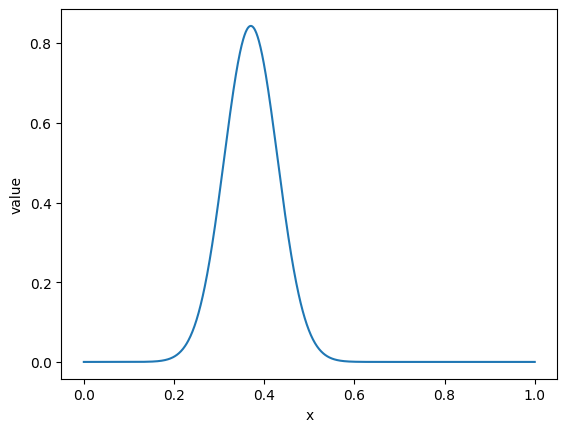

In [243]:
q_next = np.zeros(x_points) 
q_current = waves[current_wave]
x_axis_for_points = np.linspace(0,x_length,x_points)
delta_x_points = x_length/x_points
for _ in t_array:
    #setting transitive boundary conditions 
    q_next[0] = q_current[0]-(u_hat*delta_t/delta_x_points)*(q_current[0]-q_current[x_points-1])
    for i in range(1,x_points):
        q_next[i] = q_current[i]-(u_hat*delta_t/delta_x_points)*(q_current[i]-q_current[i-1])
    q_current = q_next
    if (show_plot == timesteps//number_of_plots_to_show):
        plot_scheme(fig, ax, x_axis_for_points, q_current)
        show_plot = 0
    show_plot = show_plot + 1

Calculating the error at t=2 with A.17:

In [ ]:
#we take Q_i and compare the the average of the points in the interval for the exact solution 

data = np.zeros(x_points+1)
Q_exact = np.zeros(n_integrals)
average_counter = 1
interval_counter = 0
average = 0
for i in range(0,x_intervals):
    data[i] = calculate_exact_state_1wave(waves[current_wave], x[i], t_array[-1], u_hat, -4, 8/x_points, current_wave == 2)
    average = average + (data[i]/p_in_integrals)
    if (average_counter == p_in_integrals):
        Q_exact[interval_counter] = average
        interval_counter = interval_counter + 1
        average = 0
        average_counter = 0
    average_counter = average_counter + 1

error_sum = 0
for i in range(0,n_integrals):
    error_sum = error_sum + abs(Q_exact[i]-Q_current[i])
    
print("Summed absolute error: " + str(error_sum/n_integrals))
    

TypeError: calculate_exact_state_1wave() missing 1 required positional argument: 'dam_break'

Trying to use the scheme:

$$Q_i^{n+1} = Q_i^n - \frac{\hat{u}\Delta t}{2\Delta x}(Q_{i+1}^n-Q_{i-1}^n)$$

In [ ]:
Q_current = Q_0
for _ in range(0,timesteps):
    #setting 0 instream on the left boundary
    Q_next[0] = Q_current[0]-(u_hat*delta_t/(2*delta_x))*(Q_current[1]-Q_current[n_integrals-1])
    for i in range(1,n_integrals-1):
        Q_next[i] = Q_current[i]-(u_hat*delta_t/(2*delta_x))*(Q_current[i+1]-Q_current[i-1])
    Q_next[n_integrals-1] = Q_current[n_integrals-1]-(u_hat*delta_t/(2*delta_x))*(Q_current[0]-Q_current[n_integrals-2])
    Q_current = Q_next
    if (show_plot == timesteps//20):
        ax.cla()
        ax.plot(x_axis,Q_current)
        ax.set_xlabel('x')
        ax.set_ylabel('value')
        display(fig)
        clear_output(wait=True)
        plt.pause(0.0001)
        show_plot = 0
    else:
        show_plot = show_plot + 1

ValueError: x and y must have same first dimension, but have shapes (800,) and (2000,)

Test the error where we have second order in space:

In [ ]:
error_sum = 0
for i in range(0,n_integrals):
    error_sum = error_sum + abs(Q_exact[i]-Q_current[i])
print("Summed absolute error: " + str(error_sum/n_integrals))


Summed absolute error: 0.0879871084069028


We evalute a second order scheme which is the Lax-Wendroff Method, given by:

$$Q_i^{n+1}=Q_i^n-\frac{\hat{u}\Delta t}{2\Delta x}(Q_{i+1}^n-Q_{i-1}^n)+\frac{1}{2}(\frac{\Delta t\hat{u}}{\Delta x})^2(Q_{i+1}^n-2Q_i^n+Q_{i-1}^n)$$

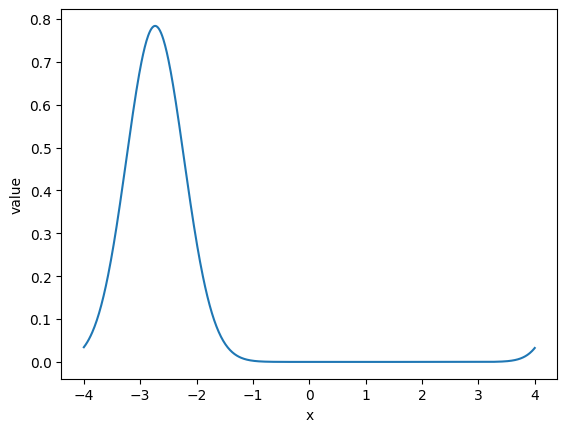

In [ ]:
Q_current = Q_0
for i in range(0,timesteps):
    Q_next[0] = Q_current[0]-(u_hat*delta_t/(2*delta_x))*(Q_current[1]-Q_current[n_integrals-1])+1/2*(u_hat*delta_t/delta_x)**2*(Q_current[1]-2*Q_current[0]+Q_current[n_integrals-1])
    for i in range(1,n_integrals-1):
        Q_next[i] = Q_current[i]-(u_hat*delta_t/(2*delta_x))*(Q_current[i+1]-Q_current[i-1])+1/2*(u_hat*delta_t/delta_x)**2*(Q_current[i+1]-2*Q_current[i]+Q_current[i-1])
    Q_next[n_integrals-1] = Q_current[n_integrals-1]-(u_hat*delta_t/(2*delta_x))*(Q_current[0]-Q_current[n_integrals-2])+1/2*(u_hat*delta_t/delta_x)**2*(Q_current[0]-2*Q_current[n_integrals-1]+Q_current[n_integrals-2])
    Q_current = Q_next
    if (show_plot == timesteps//20):
        ax.cla()
        ax.plot(x_axis,Q_current)
        ax.set_xlabel('x')
        ax.set_ylabel('value')
        display(fig)
        clear_output(wait=True)
        plt.pause(0.0001)
        show_plot = 0
    else:
        show_plot = show_plot + 1

In [ ]:
error_sum = 0
for i in range(0,n_integrals):
    error_sum = error_sum + abs(Q_exact[i]-Q_current[i])
print("Summed absolute error: " + str(error_sum/n_integrals))

Summed absolute error: 0.09035367870251307
